# Testing the 'Flow Matching in 100 LOC'-code and augmenting it with Bayesian Methods

In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Normal

import sys
sys.path.append('./src/')
sys.path.append('./src/models/')

from cond_CFM import CNF, FlowMatchingLoss

import numpy as np
import normflows as nf
import os
from tqdm import tqdm
from typing import *
from zuko.utils import odeint
from models.custom_linear_flipout import custom_LinearFlipout as LinearFlipout

from matplotlib import pyplot as plt

from typing import *
from zuko.utils import odeint

from sklearn.metrics import roc_curve, auc

In [2]:
def mkdir(save_dir):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    return save_dir

def smooth(x, kernel_size=5):
    if kernel_size == 1:
        return x
    else:
        assert kernel_size % 2 != 0
        x_shape = x.shape
        x_tmp = np.array([x[i:x_shape[0]-kernel_size+i+1] for i in range(kernel_size)])
        edge1 = x[:int((kernel_size-1)/2)]
        edge2 = x[-int((kernel_size-1)/2):]
        x_out = np.concatenate((edge1, np.mean(x_tmp, 0),edge2),0)
        assert x_shape == x_out.shape
        return x_out #np.mean(np.array(x).reshape(-1, kernel_size),1)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
approximate_gaussian_inference = True
c_factor = 50

if approximate_gaussian_inference:
    save_dir = mkdir(f'./models/CFM_VIB_k{c_factor}')
else:
    save_dir = mkdir('./models/CFM/')

In [5]:
#######################
### Define the data ###
#######################

from dataloader import *

data_dim = 2 #5
save_as_try = 0
n_samples = 1000
save_dir = mkdir(mkdir(save_dir + f'/donut_{data_dim}d/')+f'{n_samples}pts/')

data_path = './data/' 

donut_args = {'u_mean':0, 'u_sigma':1, 'r_mean':4, 'r_sigma':1}
sampler = multidim_sampler(data_dim, "donut", save_path = data_path, **donut_args)

full_data = sampler.sample_data(n_samples, save_as_try = save_as_try)
test_data = sampler.sample_data(n_samples)

batch_size = 131072
dataloader = torch.utils.data.DataLoader(full_data, batch_size=batch_size, shuffle=True, num_workers=10)
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=10)

In [6]:
########################
### Define the Model ###
########################

if approximate_gaussian_inference:
    model = CNF(data_dim, conds = 0, n_nodes=[32] * 3, layer = LinearFlipout)

else:
    model = CNF(data_dim, conds = 0, n_nodes=[32] * 3)

model.to(device)

for layer in model.modules():
    if isinstance(layer, LinearFlipout):
        layer._dnn_to_bnn_flag = True
        layer.auto_sample = False 


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


saved model at ./models/CFM_VIB_k50/donut_2d/1000pts/model_199.pth


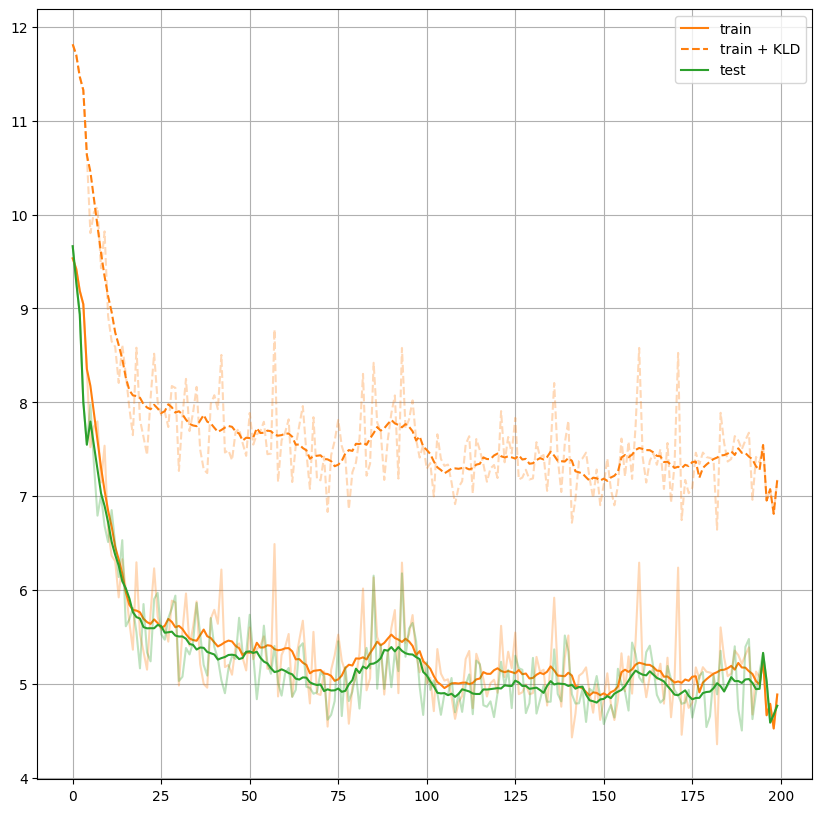

In [7]:
#####################
### Training Loop ###
#####################

train = True
lr = 1e-2
weight_decay = 0 
lr_decay = 1 #0.999

epochs = 200 #20000

if train:
    cfm_loss = FlowMatchingLoss(model)
    optim = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, lr_decay)
    model.train()

    loss_hist, loss_hist_KLD, loss_hist_test = np.array([]), np.array([]), np.array([])

    for ep in tqdm(range(epochs)):
        optim.zero_grad()
        
        for x in dataloader:
            optim.zero_grad()
            x = x.to(device)
            
            for layer in model.modules():
                if isinstance(layer, LinearFlipout):
                    layer.sample_weights()

            # Compute loss
            loss_orig = cfm_loss(x, None)
            kl_loss = torch.nan_to_num(torch.sum(torch.tensor([layer.kl_loss() for layer in model.modules() 
                                                                if isinstance(layer, LinearFlipout)],  device=device))/len(x))
            
            loss = loss_orig + c_factor*kl_loss

            # Do backprop and optimizer step
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optim.step()
                scheduler.step()
            
        # Log loss
        loss_hist = np.append(loss_hist, loss_orig.to('cpu').data.numpy())
        loss_hist_KLD = np.append(loss_hist_KLD, kl_loss.to('cpu').data.numpy())

        loss_test = 0
        for x in dataloader_test:
            x = x.to(device)
            loss_test += cfm_loss(x, None)*len(x)

        loss_hist_test = np.append(loss_hist_test, loss_test.to('cpu').data.numpy()/len(dataloader_test.dataset))


        if ep%50 == 0:
            torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")

    with open(save_dir + f'losses_{ep}.npy', 'wb') as f:
        np.save(f, loss_hist)


# # Sampling
# with torch.no_grad():
# z = torch.randn(4096, 2)
# x = flow.decode(z).numpy()


# # Log-likelihood
# with torch.no_grad():
# log_p = flow.log_prob(data[:4])

    model.eval()

    torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")
    print('saved model at ' + save_dir + f"model_{ep}.pth")

else:
    ep = epochs-1

    with open(save_dir + f'losses_{ep}.npy', 'rb') as f:
        loss_hist = np.load(f)

    model.load_state_dict(torch.load(save_dir + f"model_{ep}.pth"))
    print('loaded model from ' + save_dir + f"model_{ep}.pth")

    model.eval()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(smooth(loss_hist,1), color = 'C1', alpha = 0.3)
plt.plot(smooth(loss_hist,11), color = 'C1', label = 'train')

plt.plot(smooth(loss_hist+c_factor*loss_hist_KLD,1), color = 'C1', linestyle = '--',alpha = 0.3)
plt.plot(smooth(loss_hist+c_factor*loss_hist_KLD,11), color = 'C1', linestyle = '--', label = 'train + KLD')


plt.plot(smooth(loss_hist_test,1), color = 'C2', alpha = 0.3)
plt.plot(smooth(loss_hist_test,11), color = 'C2', label = 'test')

plt.grid()
plt.legend()
#plt.xlim(0,12500)
#plt.ylim(4,5)
img_outfile = save_dir + f"image_ep{ep}_loss.png"
plt.savefig(img_outfile)
plt.show()

In [8]:
print(sum(p.numel() for p in model.parameters()))

16260


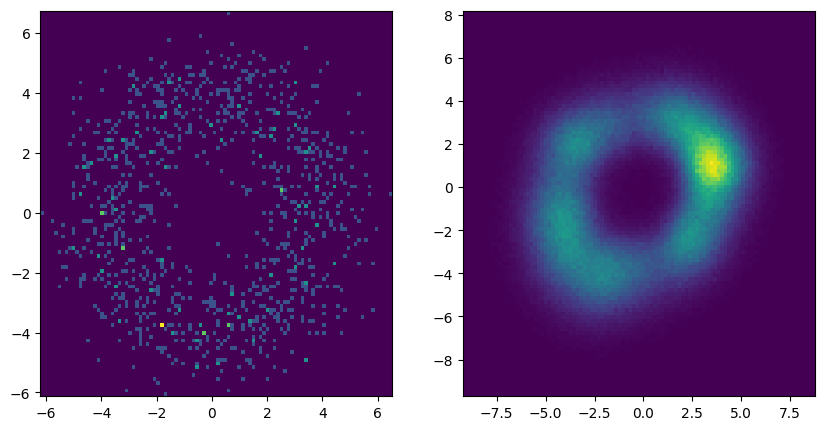

In [9]:
if approximate_gaussian_inference:
    for layer in model.modules():
        if isinstance(layer, LinearFlipout):
            layer.auto_sample = False 
            layer.sample_weights()

fig,ax = plt.subplots(1,2, figsize=(10,5))
_ = ax[0].hist2d(full_data[:,0], full_data[:,1], bins=100)

z = torch.randn(1000000, data_dim).to(device)
generated_data = model.decode(z, cond=None).detach().cpu().numpy()

_ = ax[1].hist2d(generated_data[:,0], generated_data[:,1], bins=100) 
#This is already doing better than all the DCTR and DiSCo experiments we did for the Normalizing Flows :DD
